### Optional Homework Week 4 Part 6
Make multiple (N) copies of the same image (e.g., N=10). To each copy, apply a random rotation and add some random Gaussian noise (you can test different noise levels). Using a registration function like imregister in Matlab, register the N images back (use the first image as reference, so register the other N-1 to it), and then average them. Observe if you manage to estimate the correct rotation angles and if you manage to reduce the noise. Note: Registration means that you are aligning the images again, see for example http://www.mathworks.com/help/images/ref/imregister.html or http://en.wikipedia.org/wiki/Image_registration


I wish I could take credit for this solution.  It is a (very slightly) modified version of http://nbviewer.jupyter.org/github/scikit-image/scikit-image-demos/blob/master/pano/pano.ipynb

In [1]:
from __future__ import division, print_function

import numpy as np
from matplotlib import pyplot as plt
import time

import skimage
from skimage import img_as_float, img_as_ubyte
from skimage import io
from skimage.color import rgb2gray
from skimage.util import random_noise
from skimage import transform

%matplotlib inline

In [2]:
def plot_1xc(imgs_list, titles_list, save_file=None):
    cols = len(imgs_list)
    i = 0
    
    fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,15))
    for c in range(cols):
        axes[c].imshow(imgs_list[i], cmap="gray")
        axes[c].set_title(titles_list[i], size=20)
        axes[c].set_xticks([])
        axes[c].set_yticks([])
        i = i + 1
    plt.tight_layout();
    
    if not (save_file == None):
        filename = save_file + "_" + time.strftime("%Y%m%d_%H%M") + ".png"
        fig.savefig(filename, bbox_inches='tight')
        
from skimage.feature import plot_matches

def plot_the_matches(image0, image1, keypoints1, keypoints2, matches12, title, save_file=None):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    plot_matches(ax, image0, image1, keypoints1, keypoints2, matches12)
    ax.axis('off')
    ax.set_title(title, size=20)
    
    if not (save_file == None):
        filename = save_file + "_" + time.strftime("%Y%m%d_%H%M") + ".png"
        fig.savefig(filename, bbox_inches='tight')


Original image and a modified version.  The modified version is rotated 30 degrees, scaled down by 75%, and has some gaussian noise added.

(512, 512) (384, 384)


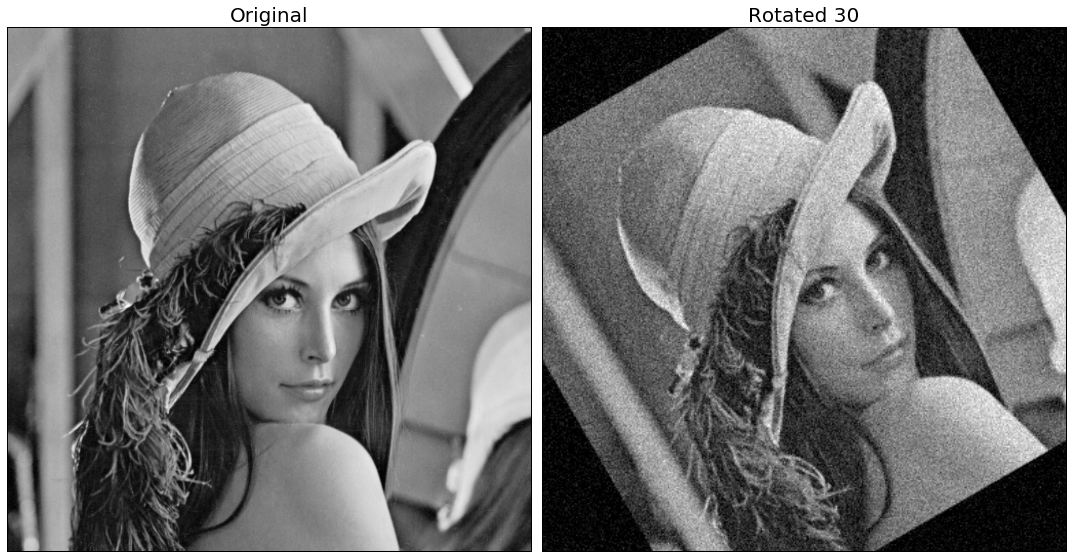

In [3]:
image0 = io.imread("../images/lena512color.tiff")
image0 = rgb2gray(image0)

image1 = transform.rotate(image0, 30)
image1 = transform.rescale(image1, .75)
image1 = random_noise(image1, mode="gaussian", var=0.005)

print(image0.shape, image1.shape)

plot_1xc([image0, image1], ["Original", "Rotated 30"], save_file="initial_images")

Feature detection with the "Oriented Fast and Rotated Brief" algorithm.  An interesting description is given by the student who implemented it in skimage for a Google Summer of Code project.  http://skimager.blogspot.com/

In [4]:
from skimage.feature import ORB, match_descriptors

orb = ORB(n_keypoints=400, fast_threshold=0.05)

orb.detect_and_extract(image0)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

orb.detect_and_extract(image1)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

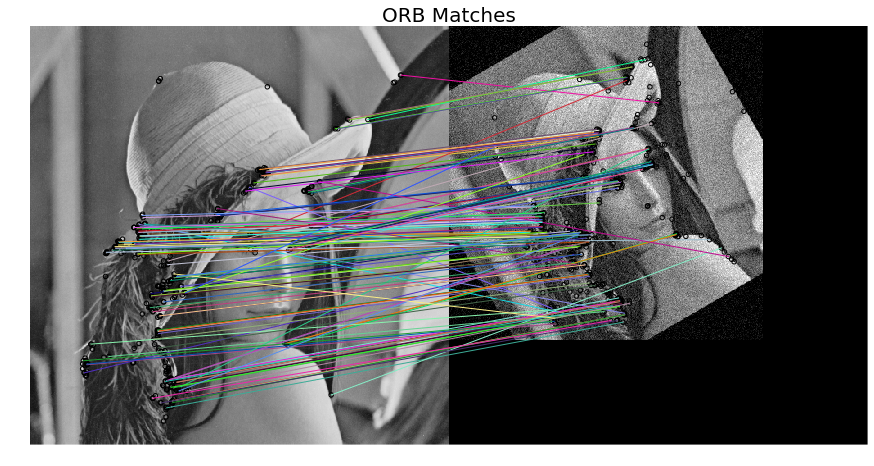

In [5]:
plot_the_matches(image0, image1, keypoints1, keypoints2, matches12, 
                 title="ORB Matches", save_file="orb_matches")

Some feature matches from ORB are inconsistent.  These are removed using the RANSAC algorithm.

"Random sample consensus (RANSAC) is an iterative method to estimate parameters of a mathematical model from a set of observed data which contains outliers."  https://en.wikipedia.org/wiki/RANSAC

In [6]:
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac
from skimage.feature import plot_matches

# Select keypoints from the source (image to be registered)
# and target (reference image)
src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

model_robust, inliers = ransac((src, dst), ProjectiveTransform,
                               min_samples=4, residual_threshold=1, max_trials=300)

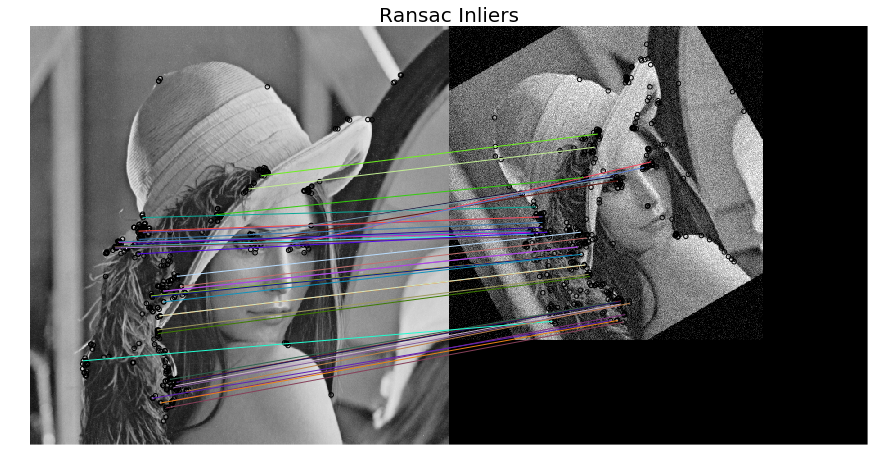

In [7]:
plot_the_matches(image0, image1, keypoints1, keypoints2, matches12[inliers], 
                 title="Ransac Inliers", save_file="ransac")

Now the images can be registered by transforming them according to the model.

In [8]:
from skimage.transform import SimilarityTransform

r, c = image1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners = model_robust(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners, corners))

corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)

output_shape = (corner_max - corner_min)
output_shape = np.ceil(output_shape[::-1])

(688, 694) (688, 694)


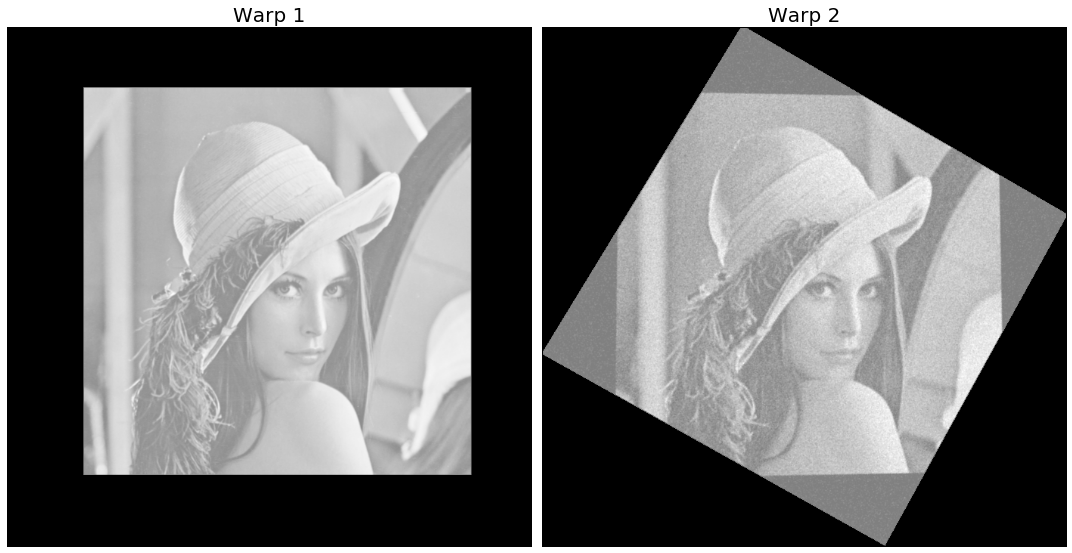

In [9]:
from skimage.color import gray2rgb
from skimage.exposure import rescale_intensity
from skimage.transform import warp

offset = SimilarityTransform(translation=-corner_min)

image0_ = warp(image0, offset.inverse,
               output_shape=output_shape, cval=-1)

image1_ = warp(image1, (model_robust + offset).inverse,
               output_shape=output_shape, cval=-1)

print(image0_.shape, image1_.shape)
plot_1xc([image0_, image1_],["Warp 1", "Warp 2"], save_file="registered_images")